In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Data Visulization.............
path = 'training_set'
classes = os.listdir(path)
classes

['lung_aca', 'lung_n', 'lung_scc']

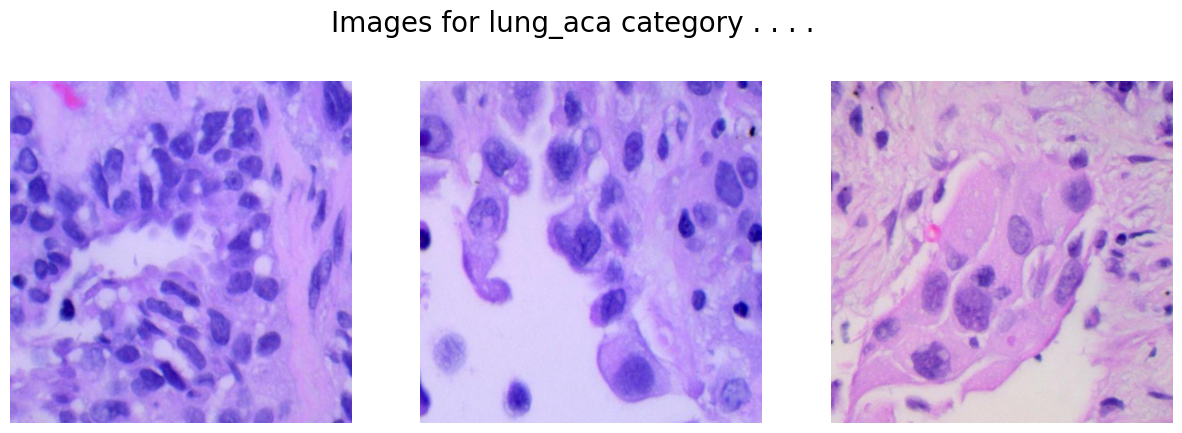

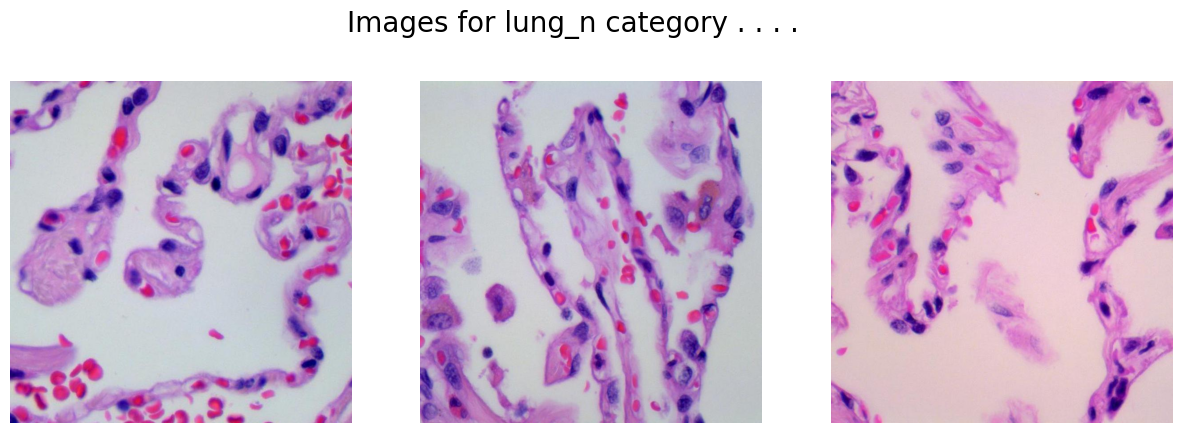

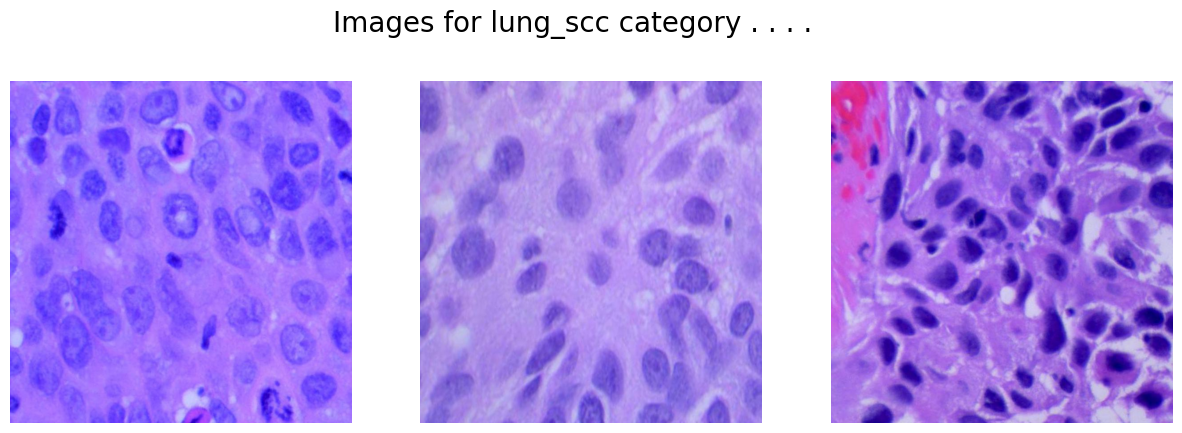

In [3]:
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{image_dir}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [4]:
# Data Preparation....
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

In [5]:
X = []
Y = []

for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.jpeg')

    for image in images:
        img = cv2.imread(image)
        X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
        Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values


In [6]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y, test_size=SPLIT, random_state=2022)
print(X_train.shape, X_val.shape)

(9600, 256, 256, 3) (2400, 256, 256, 3)


In [7]:
# Model Development..............
model = keras.models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3), padding='same'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])


In [8]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,684,291 (128.50 MB)

 Trainable params: 33,683,523 (128.49 MB)

 Non-trainable params: 768 (3.00 KB)

In [9]:
keras.utils.plot_model(
	model,
	show_shapes = True,
	show_dtype = True,
	show_layer_activations = True
)


You must install pydot (`pip install pydot`) for `plot_model` to work.


In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [11]:
#Callbacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.95:
            print('\nValidation accuracy has reached 90%, stopping further training.')
            self.model.stop_training = True

es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)


In [12]:
# Training............
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, callbacks=[es, lr, myCallback()])


Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 296s 2s/step - accuracy: 0.7778 - loss: 0.5159 - val_accuracy: 0.6538 - val_loss: 1.1655 - learning_rate: 0.0010
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.9006 - loss: 0.2457 - val_accuracy: 0.7525 - val_loss: 0.7392 - learning_rate: 0.0010
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.9306 - loss: 0.1905 - val_accuracy: 0.6575 - val_loss: 2.8479 - learning_rate: 0.0010
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9400 - loss: 0.1487
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
150/150 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.9400 - loss: 0.1487 - val_accuracy: 0.6342 - val_loss: 1.7367 - learning_rate: 0.0010
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.9711 - loss: 0.0881 - val_accuracy: 0.5029 - val_loss: 2.3930 - learning_rate: 5.0000e-04


In [13]:
model.save('lung_cancer_detection_model.h5')

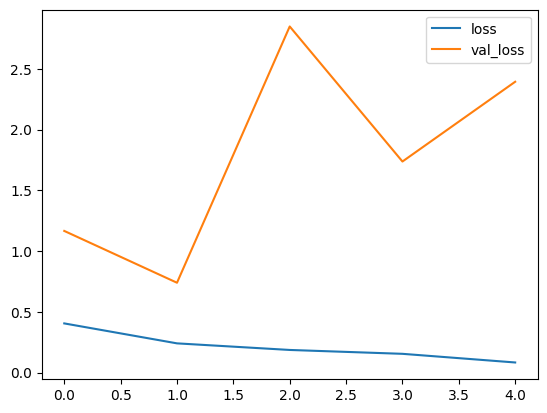

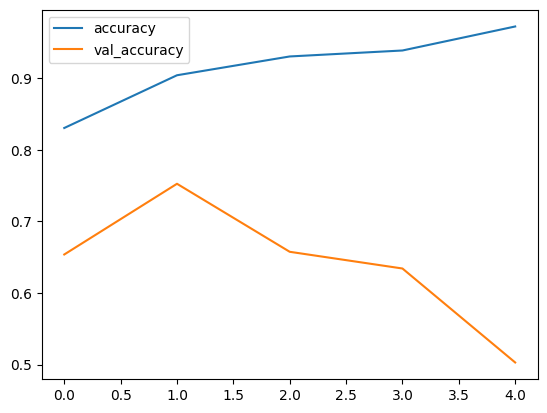

In [14]:
#Evaluation..
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()


In [15]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 229ms/step


In [16]:
print(metrics.confusion_matrix(Y_val, Y_pred))


[[255  16 551]
 [ 14 782   0]
 [ 13   0 769]]


In [17]:
print(metrics.classification_report(Y_val, Y_pred, target_names=classes))

              precision    recall  f1-score   support

    lung_aca       0.90      0.31      0.46       822
      lung_n       0.98      0.98      0.98       796
    lung_scc       0.58      0.98      0.73       782

    accuracy                           0.75      2400
   macro avg       0.82      0.76      0.72      2400
weighted avg       0.82      0.75      0.72      2400



In [18]:
loaded_model = keras.models.load_model('lung_cancer_detection_model.h5')

In [19]:
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
# Making Predictions.....
def predict_image(image_path):
    if not os.path.isfile(image_path):
        raise FileNotFoundError(f"File {image_path} does not exist")
    
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to read image from {image_path}")

    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_array = np.expand_dims(img_resized, axis=0)

    prediction = loaded_model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    return classes[predicted_class]


In [21]:
image_path = 'test_set/lung_n/lungn4002.jpeg'
print(f"Checking file path: {os.path.isfile(image_path)}")
predicted_class = predict_image(image_path)
print(f'The predicted class for the image is: {predicted_class}')

Checking file path: True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
The predicted class for the image is: lung_n
